<a href="https://www.kaggle.com/code/kaizor11/modeling-tweet-sentiments-and-stocks-prediction?scriptVersionId=221729162" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction
Prediction stock returns using (LSTM) sentiment scores from stock-related tweets using multi-task method. Original dataset uses each day as the record timeframe, so we group the data by stock and date. Full dataset was split into 3 subsets based on total tweet counts to account for potential effects from the variation: 
- 1) top 5 stocks (50% of total) `df_top_cleaned`
- 2) next 5 stocks (25%) `df_mid_cleaned`
- 3) remaining stocks (25%) `df_bot_cleaned`

Classification task (for direction of stock return: pos/neg)

Regression task (for magnitude of return)

For both sets of tasks, CV is used to improve model robustness and generalizability

# Pre-process

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_top_cleaned = pd.read_csv("/kaggle/input/cleaning-tweet-sentiments-and-stocks-prediction/df_top_cleaned.csv")
df_mid_cleaned = pd.read_csv("/kaggle/input/cleaning-tweet-sentiments-and-stocks-prediction/df_mid_cleaned.csv")
df_bot_cleaned = pd.read_csv("/kaggle/input/cleaning-tweet-sentiments-and-stocks-prediction/df_bot_cleaned.csv")

## Dates column
Dates are non-consecutive outisde of (2018-7-11 to 2018-10-2) so we'll exclude those values

In [3]:
df_top_cleaned['DATE'] = pd.to_datetime(df_top_cleaned['DATE'])
df_mid_cleaned['DATE'] = pd.to_datetime(df_mid_cleaned['DATE'])
df_bot_cleaned['DATE'] = pd.to_datetime(df_bot_cleaned['DATE'])

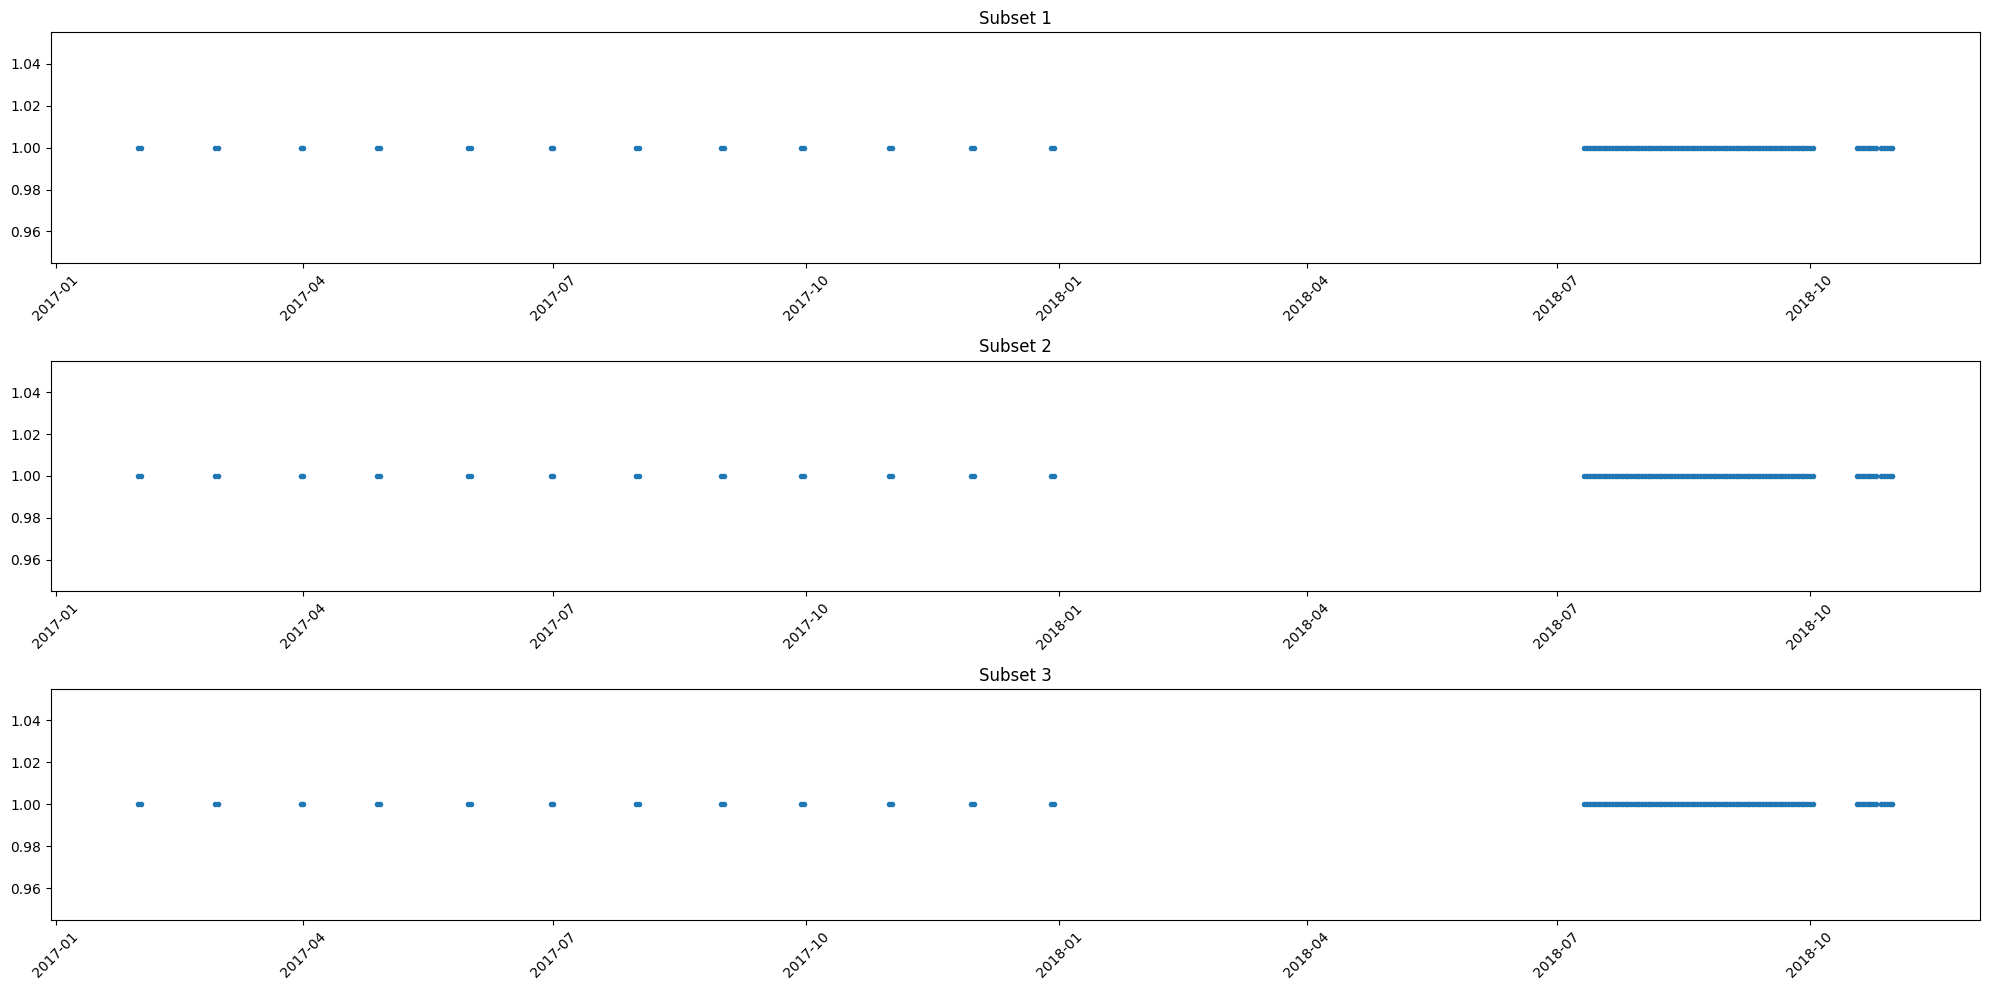

In [4]:
# Dates seems to be non-concsecutive until 2018-7-11
fig, ax, = plt.subplots(3, 1, figsize=(20, 10))
id=0
for df in [df_top_cleaned, df_mid_cleaned, df_bot_cleaned]:
    dates = df['DATE'].sort_values().unique()
    ax[id].scatter(x=dates, y=[1]*len(dates), marker='.')
    ax[id].tick_params(axis='x', rotation=45)
    ax[id].set_title(f"Subset {id + 1}")
    id += 1
plt.tight_layout()
plt.show()

In [5]:
# zooming in at the data break in oct 2018
df_top_cleaned['DATE'].sort_values().unique()[100:120]

<DatetimeArray>
['2018-09-25 00:00:00', '2018-09-26 00:00:00', '2018-09-27 00:00:00',
 '2018-09-28 00:00:00', '2018-09-29 00:00:00', '2018-09-30 00:00:00',
 '2018-10-01 00:00:00', '2018-10-02 00:00:00', '2018-10-18 00:00:00',
 '2018-10-19 00:00:00', '2018-10-20 00:00:00', '2018-10-21 00:00:00',
 '2018-10-22 00:00:00', '2018-10-23 00:00:00', '2018-10-24 00:00:00',
 '2018-10-25 00:00:00', '2018-10-27 00:00:00', '2018-10-28 00:00:00',
 '2018-10-29 00:00:00', '2018-10-30 00:00:00']
Length: 20, dtype: datetime64[ns]

In [6]:
# Function to slice dataframe to keep only dates after 2018-7-11
def slice_date(df):
    df = df[(df['DATE'] >= '2018-7-11') & (df['DATE'] <= '2018-10-2')].sort_values(by='DATE')
    df = df.reset_index(drop=True)
    return df

df_top_cleaned = slice_date(df_top_cleaned)
df_mid_cleaned = slice_date(df_mid_cleaned)
df_bot_cleaned = slice_date(df_bot_cleaned)

## Null values

In [7]:
print(df_top_cleaned.isnull().sum())
print(df_mid_cleaned.isnull().sum())
print(df_bot_cleaned.isnull().sum())
df_bot_cleaned = df_bot_cleaned.dropna() # ok since we're only dropping 1 row

TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    0
dtype: int64
TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    0
dtype: int64
TWEET                0
STOCK                0
DATE                 0
LAST_PRICE           0
1_DAY_RETURN         0
2_DAY_RETURN         0
3_DAY_RETURN         0
7_DAY_RETURN         0
PX_VOLUME            0
VOLATILITY_10D       0
VOLATILITY_30D       0
LSTM_POLARITY        0
TEXTBLOB_POLARITY    1
dtype: int64


In [8]:
print(df_top_cleaned['STOCK'].unique())
print(df_mid_cleaned['STOCK'].unique())
print(df_bot_cleaned['STOCK'].unique())

['Google' 'Facebook' 'Ford' 'Apple' 'Next']
['Amazon' 'Netflix' 'Nike' 'Disney' 'Starbucks']
['Visa' 'BMW' 'Comcast' 'PayPal' 'adidas' 'Microsoft' 'HP' 'Yahoo'
 'Samsung' 'Pfizer' 'Kroger' 'Ryanair' 'Verizon' 'eBay' "McDonald's"
 'Toyota' 'Walmart' 'BP' 'Sony' 'Intel' 'Cisco' 'CBS' 'Honda' 'Costco'
 'FedEx' 'Reuters' 'Burberry' 'Mastercard' 'IBM' 'Exxon' 'Gillette' 'Audi'
 'Heineken' 'Nestle' 'UPS' 'Siemens' 'BASF' 'Chevron' 'SAP' 'ASOS' 'Pepsi'
 'Nissan' 'Groupon' 'Shell' 'Hyundai' 'Colgate' 'Tesco' 'Adobe' 'Allianz'
 'Citigroup' 'Oracle' 'Bayer' "Kellogg's" 'Carrefour' 'Santander'
 'TripAdvisor' 'JPMorgan' 'CocaCola' 'Vodafone' 'HSBC' 'AstraZeneca'
 'Boeing' 'GSK' 'BlackRock' 'Thales' 'Aviva' 'Expedia' 'TMobile' 'easyJet'
 'Danone' 'Viacom' "L'Oreal" 'Equinor' '21CF' 'AT&T' 'Bank of America'
 'American Express' 'Home Depot' 'bookingcom' 'Morgan Stanley'
 'salesforce.com' 'Volkswagen' 'Goldman Sachs' 'Deutsche Bank'
 'Wells Fargo' 'H&M' 'General Electric' 'P&G' 'John Deere'
 'Cardinal

## Duplicates
A lot of duplicate data (mostly from retweets). We keep them because we are interested in overall twitter sentiment

In [9]:
print(df_top_cleaned[df_top_cleaned.duplicated()])

                                                    TWEET  STOCK       DATE  \
14      RT @Mhm_Right: I’m at Popeyes and this happene...  Apple 2018-07-11   
48      RT @Mhm_Right: I’m at Popeyes and this happene...  Apple 2018-07-11   
52      @_AsheleyNicole_ @TheRealTyBarber @_loganalexi...   Next 2018-07-11   
58      RT @Mhm_Right: I’m at Popeyes and this happene...  Apple 2018-07-11   
61      RT @Mhm_Right: I’m at Popeyes and this happene...  Apple 2018-07-11   
...                                                   ...    ...        ...   
148891  RT @ProfMJCleveland: THREAD: For those thinkin...   Ford 2018-10-02   
148899  RT @Golfinggary5222: WOW! Hmmm did Ford use hy...   Ford 2018-10-02   
148901  RT @StefanMolyneux: If I were still single, I ...   Ford 2018-10-02   
148902  RT @PastorDScott: Rachel Mitchell said “In oth...   Ford 2018-10-02   
148906  RT @SMTOWNGLOBAL: NCT 127 is becoming so big g...  Apple 2018-10-02   

        LAST_PRICE  1_DAY_RETURN  2_DAY_RETURN  3_D

## Grouping values

In [10]:
# Group values by Stock and Date
def group_df(df):
    df_grouped = df.groupby(['STOCK', 'DATE'], as_index=False).agg({'LSTM_POLARITY':'sum', '1_DAY_RETURN':'mean', 'PX_VOLUME':'mean', 'VOLATILITY_10D':'mean'}).reset_index(drop=True)
    return df_grouped

In [11]:
df_top_final = group_df(df_top_cleaned)
df_mid_final = group_df(df_mid_cleaned)
df_bot_final = group_df(df_bot_cleaned)

## Direction feature (for classification task)
`1` for positive `1_DAY_RETURN`, `0` otherwise

In [12]:
# Create DIRECTION feature for classfication task
def create_direction_feature(df):
    RETURN = '1_DAY_RETURN'
    df['DIRECTION'] = df[RETURN].apply(lambda x: 0 if x < 0 else 1)
    return df

df_top_final = create_direction_feature(df_top_final)
df_mid_final = create_direction_feature(df_mid_final)
df_bot_final = create_direction_feature(df_bot_final)

In [13]:
# Percentage distribution of DIRECTION. This will be taken care of in modeling
top_dir_weight = df_top_final[df_top_final['DIRECTION'] == 1].value_counts().sum()/len(df_top_final)
mid_dir_weight = df_mid_final[df_mid_final['DIRECTION'] == 1].value_counts().sum()/len(df_mid_final)
bot_dir_weight = df_bot_final[df_bot_final['DIRECTION'] == 1].value_counts().sum()/len(df_bot_final)

print(top_dir_weight)
print(mid_dir_weight)
print(bot_dir_weight)

0.6476190476190476
0.6
0.6321138211382114


In [14]:
print(df_top_final)

     STOCK       DATE  LSTM_POLARITY  1_DAY_RETURN   PX_VOLUME  \
0    Apple 2018-07-11           77.0      0.013147  18831470.0   
1    Apple 2018-07-12           61.0     -0.016490  18041131.0   
2    Apple 2018-07-13            2.0     -0.001568  12519792.0   
3    Apple 2018-07-14           -5.0      0.000000  12519792.0   
4    Apple 2018-07-15          -19.0      0.000000  12519792.0   
..     ...        ...            ...           ...         ...   
415   Next 2018-09-28           13.0     -0.029487    729746.0   
416   Next 2018-09-29          118.0      0.000000    729746.0   
417   Next 2018-09-30           81.0      0.000000    729746.0   
418   Next 2018-10-01           92.0      0.011042    458379.0   
419   Next 2018-10-02           26.0      0.014942    338916.0   

     VOLATILITY_10D  DIRECTION  
0            18.568          1  
1            20.021          0  
2            19.797          0  
3            19.797          1  
4            19.797          1  
..       

In [15]:
print(df_mid_final)

         STOCK       DATE  LSTM_POLARITY  1_DAY_RETURN   PX_VOLUME  \
0       Amazon 2018-07-11           35.0     -0.006798   3209782.0   
1       Amazon 2018-07-12            7.0     -0.023166   4532743.0   
2       Amazon 2018-07-13            0.0     -0.009051   4386679.0   
3       Amazon 2018-07-14           -1.0      0.000000   4386679.0   
4       Amazon 2018-07-15            4.0      0.000000   4386679.0   
..         ...        ...            ...           ...         ...   
415  Starbucks 2018-09-28           -8.0      0.008797   8975955.0   
416  Starbucks 2018-09-29           11.0      0.000000   8975955.0   
417  Starbucks 2018-09-30            0.0      0.000000   8975955.0   
418  Starbucks 2018-10-01            7.0      0.022670  12727584.0   
419  Starbucks 2018-10-02           14.0     -0.000180  12680838.0   

     VOLATILITY_10D  DIRECTION  
0            16.439          0  
1            16.113          0  
2            15.588          0  
3            15.588        

In [16]:
print(df_bot_final)

               STOCK       DATE  LSTM_POLARITY  1_DAY_RETURN  PX_VOLUME  \
0               21CF 2018-08-10            1.0      0.002639  5206734.0   
1               21CF 2018-09-05            0.0      0.001547  7801635.0   
2               ASOS 2018-07-11           -1.0      0.008923   217525.0   
3               ASOS 2018-07-15           -2.0      0.000000   846417.0   
4               ASOS 2018-07-17           -1.0     -0.045575   678881.0   
...              ...        ...            ...           ...        ...   
4915  salesforce.com 2018-09-26            0.0      0.003411  4079727.0   
4916  salesforce.com 2018-09-27            5.0     -0.013090  3930274.0   
4917  salesforce.com 2018-09-29            1.0      0.000000  4607671.0   
4918  salesforce.com 2018-09-30           -1.0      0.000000  4607671.0   
4919  salesforce.com 2018-10-01            0.0     -0.005192  4297554.0   

      VOLATILITY_10D  DIRECTION  
0              7.018          1  
1              6.489          1

# EDA
Correlation heatmap and pairplots for each subset

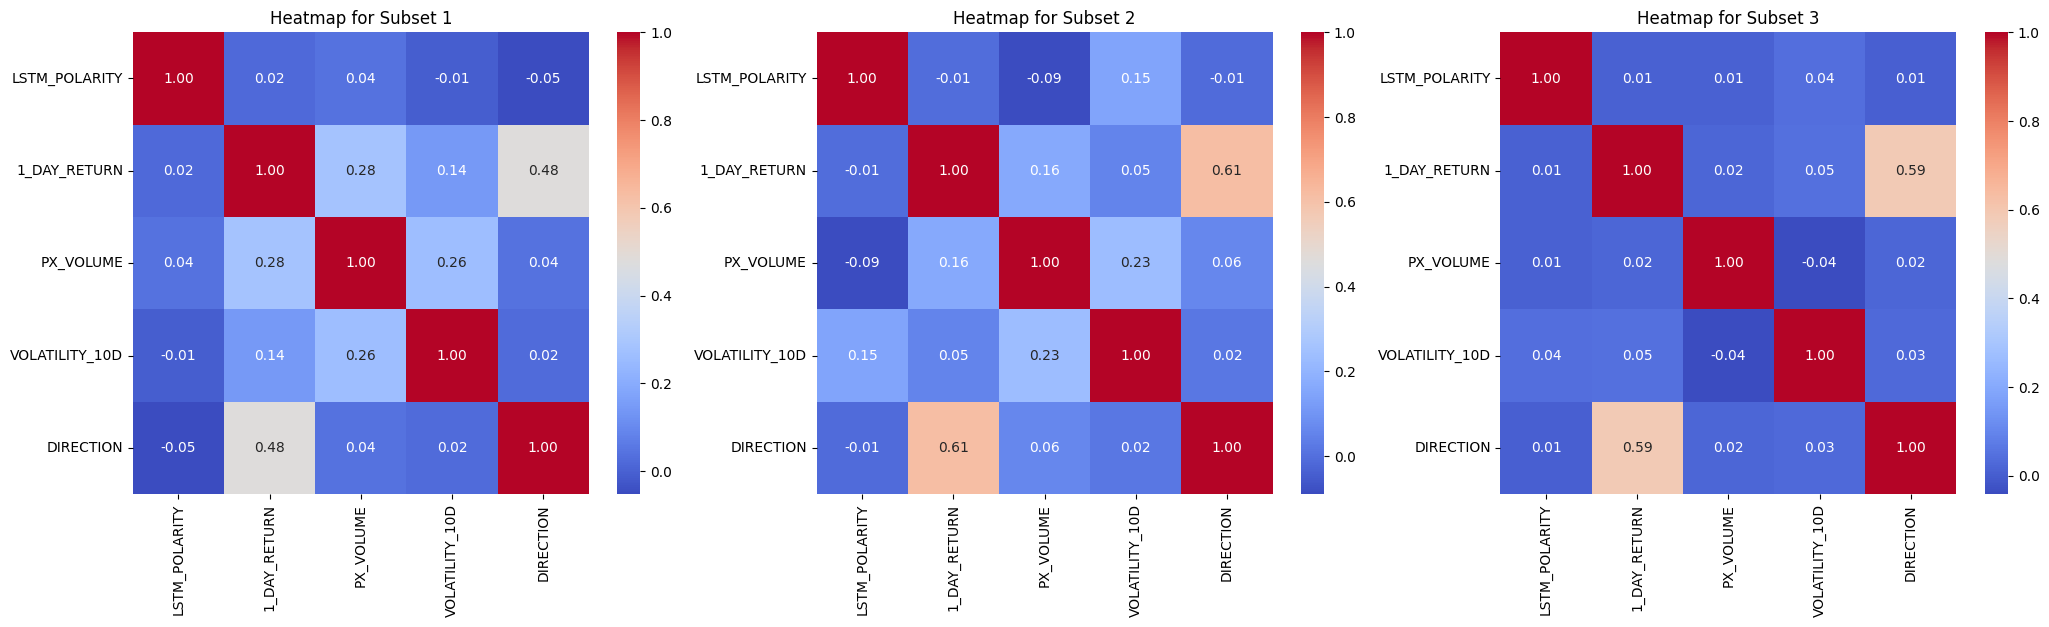

In [17]:
# Create Heatmaps
fig, axes = plt.subplots(1, 3, figsize=(25, 6))
idx = 0

for df in [df_top_final, df_mid_final, df_bot_final]:
    
    # Feature correlation and relationship
    VAR = df.iloc[:, 2:]
    
    correlation_matrix = VAR.corr()

    sns.heatmap(correlation_matrix, ax=axes[idx], cmap="coolwarm", fmt=".2f", annot=True)
    axes[idx].set_title(f"Heatmap for Subset {idx+1}")
    idx+=1

plt.show()

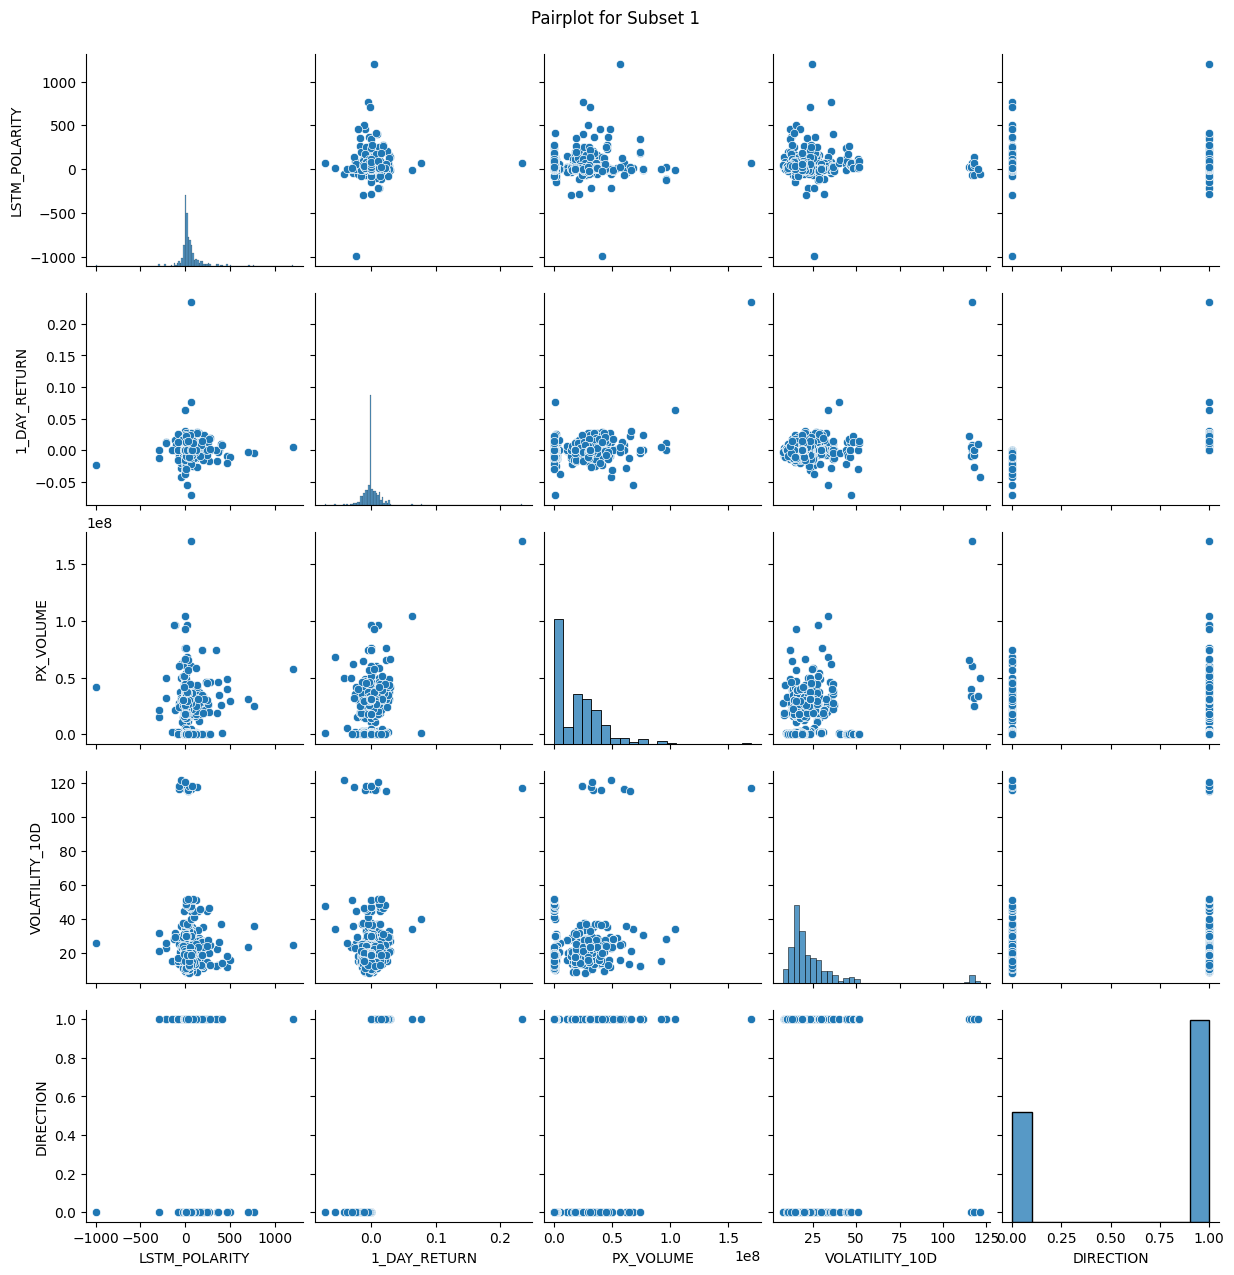

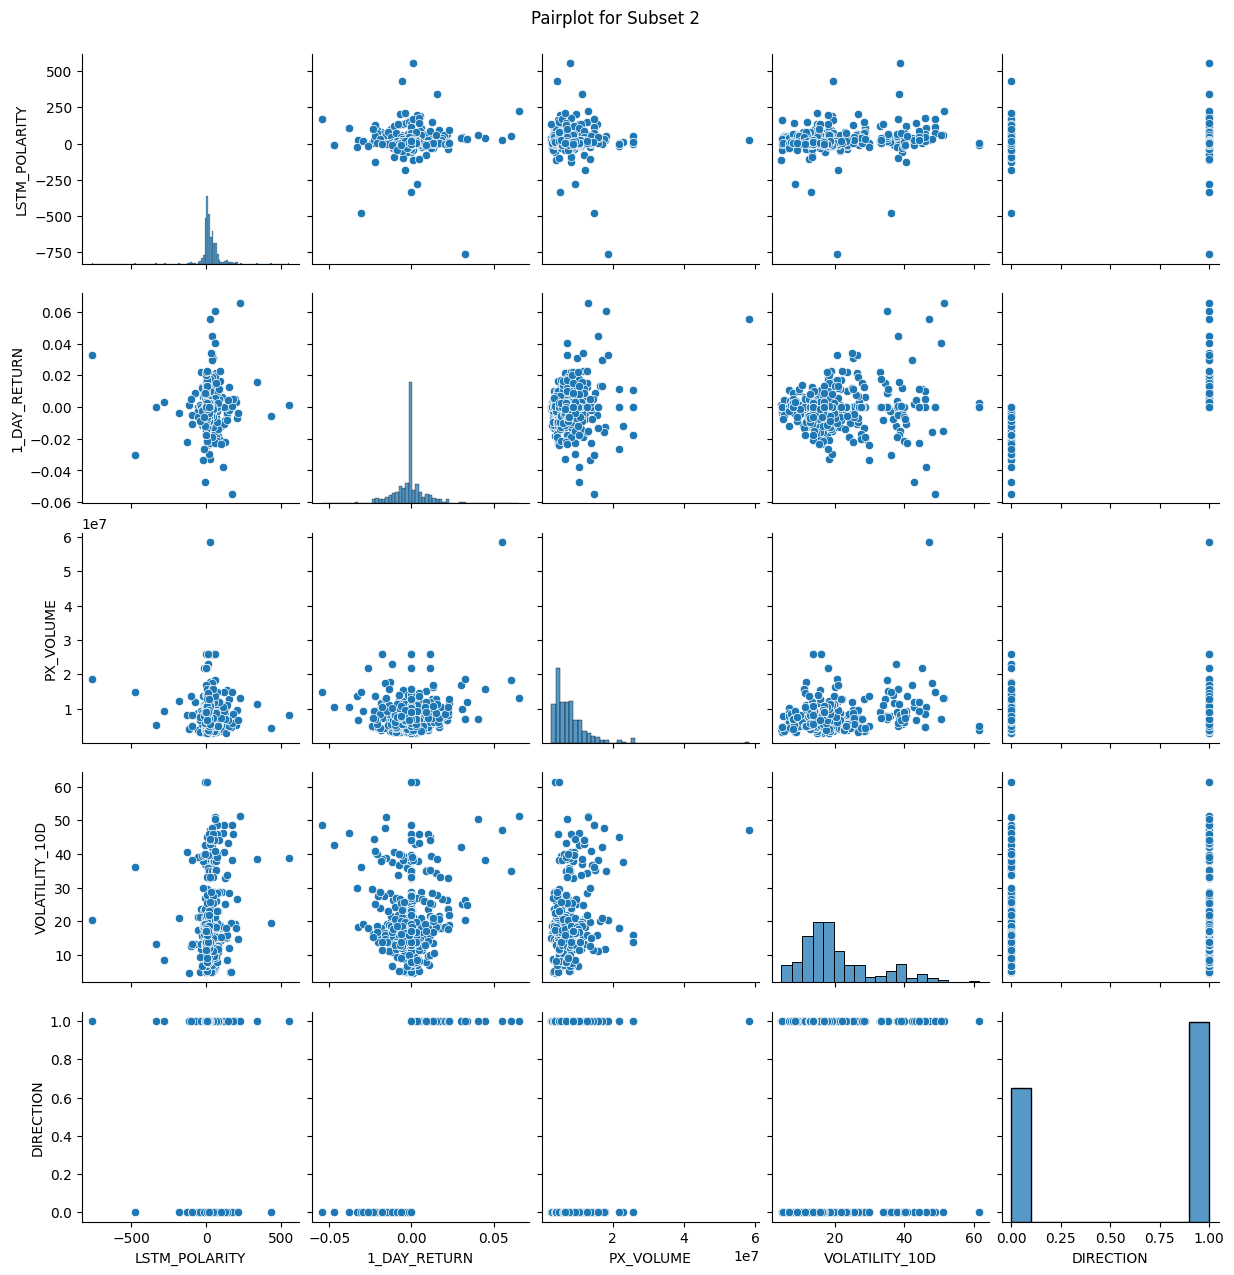

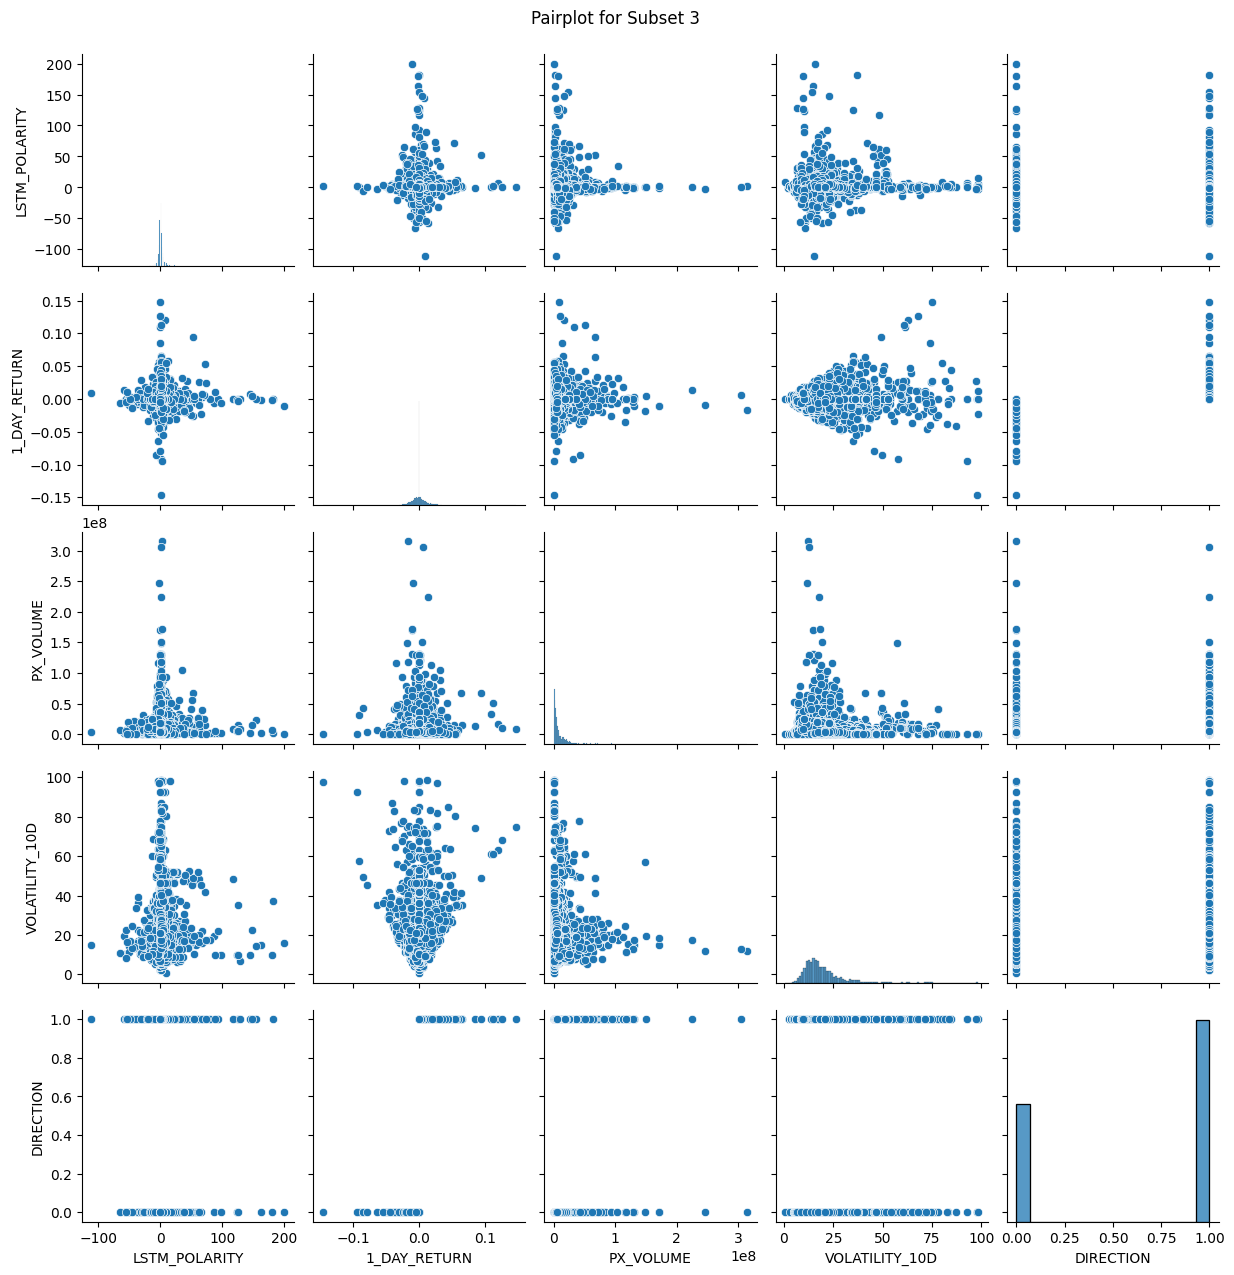

In [18]:
# Create pairplots
# fig, axes = plt.subplots(1, 3, figsize=(25, 6))
idx = 0

for df in [df_top_final, df_mid_final, df_bot_final]:
    
    # Feature correlation and relationship
    VAR = df.iloc[:, 2:]
    
    sns.pairplot(VAR)
    # axes[idx].set_title(f"Pairplot for df {idx+1}")
    plt.suptitle(f"Pairplot for Subset {idx+1}", y=1.02)
    idx+=1
    plt.show()

# ML setup

In [19]:
SEED = 42

FEATURES = ['LSTM_POLARITY', 'VOLATILITY_10D', 'PX_VOLUME']
# FEATURES = ['LSTM_POLARITY']
CLASS_TARGET = 'DIRECTION'
REG_TARGET = '1_DAY_RETURN'

In [20]:
# Normalize 'VOLATILITY_10D', 'PX_VOLUME' for the linear models
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
num_cols = ['VOLATILITY_10D', 'PX_VOLUME']

for df in [df_top_final, df_mid_final, df_bot_final]:
    scaler.fit(df[num_cols])
    df = scaler.transform(df[num_cols])

In [21]:
# Train test split for time series and X y definition
from sklearn.model_selection import TimeSeriesSplit

X_top = df_top_final[FEATURES]
y_top = df_top_final[CLASS_TARGET]

X_mid = df_mid_final[FEATURES]
y_mid = df_mid_final[CLASS_TARGET]

X_bot = df_bot_final[FEATURES]
y_bot = df_bot_final[CLASS_TARGET]

X_set = [X_top, X_mid, X_bot]
y_set = [y_top, y_mid, y_bot]

# Split time series into 5 folds for CV
tscv = TimeSeriesSplit(n_splits=5)

# Classification Tasks
- Random Forest
- SVC (SVM)
- XGBoost
- Logit

In [22]:
# Models to test
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Assigning class weights because distribution of 'DIRECTION' is not balanced. Data from direction creation cell
# weight = 1/(frequency of class)
weights_top = {0: 1/(1-top_dir_weight), 1: 1/top_dir_weight }
weights_mid = {0: 1/(1-mid_dir_weight), 1: 1/mid_dir_weight }
weights_bot = {0: 1/(1-bot_dir_weight), 1: 1/bot_dir_weight }

models = [
    RandomForestClassifier(n_estimators=1000, random_state=SEED), 
    SVC(kernel='rbf', random_state=SEED), 
    xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=SEED),
    LogisticRegression(random_state=SEED)
]

## Cross-validation Models (Classfication)

In [23]:
def evaluate_class_models_CV(models, X, y, n_splits=tscv):
    """
    Evaluate a list of classification models using accuracy with cross-validation.

    Parameters:
    models (list): List of models to evaluate
    X (pd.DataFrame or np.ndarray): Feature matrix
    y (pd.Series or np.ndarray): Target vector
    n_splits (int): Number of splits for TimeSeriesSplit cross-validation (default 5)

    Returns:
    pd.DataFrame: DataFrame with model names and mean accuracy values, sorted by mean accuracy
    """
    model_accuracy = []

    for model in models:
        # Use cross_val_score with TimeSeriesSplit for cross-validation
        accuracy_scores = cross_val_score(
            model, X, y, cv=n_splits, scoring='accuracy'
        )
        
        # Calculate the mean accuracy score
        mean_accuracy = np.mean(accuracy_scores)
        
        # Append the results to the list
        model_accuracy.append({
            'class_model_cv': type(model).__name__,
            'mean_accuracy_cv': mean_accuracy
        })
    
    # Convert the list of dictionaries to a DataFrame
    model_acc_df = pd.DataFrame(model_accuracy)
    
    # Sort the DataFrame by mean accuracy in descending order
    model_acc_df = model_acc_df.sort_values(by='mean_accuracy_cv', ascending=False).reset_index(drop=True)

    return model_acc_df

In [24]:
id = 1
for X, y in zip(X_set, y_set):
    class_models_cv = evaluate_class_models_CV(models, X, y)
    print(f"Results for subset {id}")
    print(class_models_cv, "\n")
    id+=1

Results for subset 1
           class_model_cv  mean_accuracy_cv
0      LogisticRegression          0.665714
1                     SVC          0.648571
2  RandomForestClassifier          0.568571
3           XGBClassifier          0.502857 

Results for subset 2
           class_model_cv  mean_accuracy_cv
0      LogisticRegression          0.605714
1                     SVC          0.588571
2           XGBClassifier          0.482857
3  RandomForestClassifier          0.480000 

Results for subset 3
           class_model_cv  mean_accuracy_cv
0      LogisticRegression          0.638780
1                     SVC          0.638537
2  RandomForestClassifier          0.561463
3           XGBClassifier          0.555610 



In [25]:
# apply classification models to each individual stock
def indiviual_stock_class(data):
    set = list(data['STOCK'].astype(str).unique())
    for stock in set:
        df = data[data['STOCK'] == stock]
        dfx = df[FEATURES]
        dfy = df[CLASS_TARGET]
        result = evaluate_class_models_CV(models, dfx, dfy)
        print(f"Results for {stock}")
        print(result, "\n")

In [26]:
indiviual_stock_class(df_top_final)

Results for Apple
           class_model_cv  mean_accuracy_cv
0                     SVC          0.500000
1  RandomForestClassifier          0.471429
2      LogisticRegression          0.414286
3           XGBClassifier          0.400000 

Results for Facebook
           class_model_cv  mean_accuracy_cv
0      LogisticRegression          0.700000
1                     SVC          0.685714
2  RandomForestClassifier          0.600000
3           XGBClassifier          0.414286 

Results for Ford
           class_model_cv  mean_accuracy_cv
0                     SVC          0.642857
1      LogisticRegression          0.642857
2           XGBClassifier          0.585714
3  RandomForestClassifier          0.542857 

Results for Google
           class_model_cv  mean_accuracy_cv
0                     SVC          0.628571
1      LogisticRegression          0.614286
2           XGBClassifier          0.471429
3  RandomForestClassifier          0.428571 

Results for Next
           class_mod

## Baseline Models (Classification)

In [27]:
def evaluate_class_models(models, X, y):
    """
    Evaluate a list of classification models using accuracy with cross-validation.

    Parameters:
    models (list): List of models to evaluate
    X (pd.DataFrame or np.ndarray): Feature matrix
    y (pd.Series or np.ndarray): Target vector

    Returns:
    pd.DataFrame: DataFrame with model names and accuracy values, sorted by accuracy
    """
    # Specify the split ratio (e.g., 80% for training and 20% for testing)
    train_size = int(len(X) * 0.8)
    
    # Split the data manually
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # List for accuracy score for each model
    model_accuracy = []

    for model in models:
        # Use cross_val_score with TimeSeriesSplit for cross-validation
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        # Calculate the accuracy score
        score = accuracy_score(y_test, y_pred)
        
        # Append the results to the list
        model_accuracy.append({
            'class_model': type(model).__name__,
            'accuracy': score
        })
    
    # Convert the list of dictionaries to a DataFrame
    model_acc_df = pd.DataFrame(model_accuracy)
    
    # Sort the DataFrame by mean accuracy in descending order
    model_acc_df = model_acc_df.sort_values(by='accuracy', ascending=False).reset_index(drop=True)

    return model_acc_df

In [28]:
id = 1
for X, y in zip(X_set, y_set):
    class_models = evaluate_class_models(models, X, y)
    print(f"Results for subset {id}")
    print(class_models, "\n")
    id+=1

Results for subset 1
              class_model  accuracy
0                     SVC  0.702381
1      LogisticRegression  0.702381
2  RandomForestClassifier  0.666667
3           XGBClassifier  0.559524 

Results for subset 2
              class_model  accuracy
0                     SVC  0.571429
1      LogisticRegression  0.571429
2  RandomForestClassifier  0.488095
3           XGBClassifier  0.440476 

Results for subset 3
              class_model  accuracy
0                     SVC  0.646341
1      LogisticRegression  0.646341
2  RandomForestClassifier  0.592480
3           XGBClassifier  0.583333 



# Regression Tasks
- Random Forest
- SVR (SVM for regression)
- XGBoost
- Lasso
- Linear

In [29]:
# Models to test
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.linear_model import Lasso, LinearRegression

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Assuming X and y are your features and target
models = [
    RandomForestRegressor(n_estimators=1000, random_state=SEED), 
    SVR(kernel='rbf'), 
    Lasso(random_state=SEED),
    xgb.XGBRegressor(objective='reg:squarederror', random_state=SEED),
    LinearRegression()
]

## Cross-validation Models (Regression)

In [30]:
def evaluate_reg_models_CV(models, X, y, n_splits=tscv):
    """
    Evaluate a list of models using MSE with TimeSeriesSplit cross-validation.

    Parameters:
    models (list): List of models to evaluate
    X (pd.DataFrame or np.ndarray): Feature matrix
    y (pd.Series or np.ndarray): Target vector
    n_splits (int): Number of splits for TimeSeriesSplit cross-validation (default 5)

    Returns:
    pd.DataFrame: DataFrame with model names, mean MSE values, and normalized MSE values, sorted by normalized MSE
    """
    model_mse = []

    for model in models:
        # Use cross_val_score with TimeSeriesSplit for cross-validation
        mse_scores = cross_val_score(
            model, X, y, cv=n_splits, scoring='neg_mean_squared_error'
        )
        
        # Calculate the mean MSE (since cross_val_score returns negative MSE, negate it)
        mean_mse = -np.mean(mse_scores)
        norm_mse = mean_mse / np.var(y)
        
        # Append the results to the list
        model_mse.append({
            'reg_model_cv': type(model).__name__,
            'mean_mse_cv': mean_mse,
            'norm_mse_cv': norm_mse
        })
    
    # Convert the list of dictionaries to a DataFrame
    model_mse_df = pd.DataFrame(model_mse)
    
    # Sort the DataFrame by normalized MSE in ascending order
    model_mse_df = model_mse_df.sort_values(by='norm_mse_cv').reset_index(drop=True)

    return model_mse_df

In [31]:
id = 1
for X, y in zip(X_set, y_set):
    reg_models_cv = evaluate_reg_models_CV(models, X, y)
    print(f"Results for subset {id}")
    print(reg_models_cv, "\n")
    id+=1

Results for subset 1
            reg_model_cv  mean_mse_cv  norm_mse_cv
0                  Lasso     0.229554     1.005894
1       LinearRegression     0.231277     1.013443
2  RandomForestRegressor     0.269070     1.179054
3                    SVR     0.278803     1.221700
4           XGBRegressor     0.352826     1.546067 

Results for subset 2
            reg_model_cv  mean_mse_cv  norm_mse_cv
0                  Lasso     0.248969     1.037373
1       LinearRegression     0.256017     1.066738
2  RandomForestRegressor     0.283928     1.183034
3                    SVR     0.334014     1.391726
4           XGBRegressor     0.384923     1.603844 

Results for subset 3
            reg_model_cv  mean_mse_cv  norm_mse_cv
0                  Lasso     0.231384     0.995003
1       LinearRegression     0.231651     0.996152
2  RandomForestRegressor     0.265869     1.143297
3                    SVR     0.299184     1.286558
4           XGBRegressor     0.303611     1.305595 



In [32]:
# apply regression models to each individual stock
def indiviual_stock_reg(data):
    set = list(data['STOCK'].astype(str).unique())
    for stock in set:
        df = data[data['STOCK'] == stock]
        x = df[FEATURES]
        y = df[REG_TARGET]
        result = evaluate_reg_models_CV(models, x, y)
        print(f"Results for {stock}")
        print(result, "\n")

In [33]:
indiviual_stock_reg(df_top_final)

Results for Apple
            reg_model_cv  mean_mse_cv  norm_mse_cv
0                  Lasso     0.000188     1.596259
1  RandomForestRegressor     0.000210     1.777052
2       LinearRegression     0.000211     1.791744
3           XGBRegressor     0.000263     2.229318
4                    SVR     0.000353     2.992163 

Results for Facebook
            reg_model_cv  mean_mse_cv  norm_mse_cv
0           XGBRegressor     0.001041     1.319483
1  RandomForestRegressor     0.001057     1.339288
2                  Lasso     0.002907     3.683946
3                    SVR     0.004835     6.126593
4       LinearRegression     0.006787     8.599904 

Results for Ford
            reg_model_cv  mean_mse_cv  norm_mse_cv
0  RandomForestRegressor     0.000204     1.328952
1                  Lasso     0.000219     1.432356
2           XGBRegressor     0.000234     1.529955
3       LinearRegression     0.000408     2.663189
4                    SVR     0.000454     2.960125 

Results for Google
 

## Baseline Models (Regression)

In [34]:
def evaluate_reg_models(models, X, y):
    """
    Evaluate a list of classification models using accuracy with cross-validation.

    Parameters:
    models (list): List of models to evaluate
    X (pd.DataFrame or np.ndarray): Feature matrix
    y (pd.Series or np.ndarray): Target vector

    Returns:
    pd.DataFrame: DataFrame with model names, mse, and normalized mse, sorted by normalized mse
    """
    # Specify the split ratio (e.g., 80% for training and 20% for testing)
    train_size = int(len(X) * 0.8)
    
    # Split the data manually
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # List for accuracy score for each model
    model_mse = []

    for model in models:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        
        # Calculate MSE
        mse = mean_squared_error(y_test, y_pred)
        norm_mse = mse/np.var(y)
        
        # Append the results to the list
        model_mse.append({
            'reg_model': type(model).__name__,
            'mean_mse': mse,
            'norm_mse': norm_mse
        })
    
    # Convert the list of dictionaries to a DataFrame
    model_acc_df = pd.DataFrame(model_mse)
    
    # Sort the DataFrame by mean accuracy in descending order
    model_acc_df = model_acc_df.sort_values(by='norm_mse').reset_index(drop=True)

    return model_acc_df

In [35]:
id = 1
for X, y in zip(X_set, y_set):
    reg_models = evaluate_reg_models(models, X, y)
    print(f"Results for subset {id}")
    print(reg_models, "\n")
    id+=1

Results for subset 1
               reg_model  mean_mse  norm_mse
0                  Lasso  0.223955  0.981362
1       LinearRegression  0.224248  0.982643
2  RandomForestRegressor  0.232143  1.017242
3                    SVR  0.248184  1.087530
4           XGBRegressor  0.305663  1.339401 

Results for subset 2
               reg_model  mean_mse  norm_mse
0                  Lasso  0.244795  1.019977
1       LinearRegression  0.245781  1.024089
2  RandomForestRegressor  0.260187  1.084112
3           XGBRegressor  0.341108  1.421285
4                    SVR  0.352897  1.470402 

Results for subset 3
               reg_model  mean_mse  norm_mse
0                  Lasso  0.228664  0.983306
1       LinearRegression  0.229494  0.986876
2  RandomForestRegressor  0.267849  1.151811
3           XGBRegressor  0.282741  1.215851
4                    SVR  0.294491  1.266377 

